In [1]:
import os
import numpy as np


def find_best(checkpoint, task):
    log_files_a = os.listdir(checkpoint+"/")
    log_files_b = []

    for file in log_files_a:
        file_split = file.split(".")
        if(file_split[-1]=="txt"):
            file_split_2 = file_split[0].split("_")
            if(file_split_2[0]=="session" and file_split_2[1]==str(task) ):
                f = np.loadtxt(checkpoint+"/"+file, skiprows=1)
                best_acc = max(f[-1,-1], f[-1,-2])
                if(file_split_2[-1]!="RT"):
                    return best_acc
                    
    return best_acc


In [2]:
##### import numpy as np
from collections import Counter

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)**(1/2) 
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def get_correct(acc_task, task, chunks, start_point, class_per_task):
        correct = 0
        correct2 = 0
        task_scores = []
        class_scores = []
        targets = []
        targets_pred = []
        for t in range(task+1):
            list_0 = []
            list_1 = []
            list_2 = []
            list_3 = []
            for i in range(chunks):
                acc_task_0 = acc_task[start_point + i]
                list_0.append(acc_task_0[t][0].detach().cpu().numpy())
                list_1.append(acc_task_0[t][1].detach().cpu().numpy())
                list_2.append(acc_task_0[t][2])
                list_3.append(acc_task_0[t][3].detach().cpu().numpy())
            list_0 = np.array(list_0)
            list_1 = np.array(list_1)
            list_2 = np.array(list_2)
            list_3 = np.array(list_3)
            
            targets_pred.append(list_0)
            class_scores.append(list_1)
            task_scores.append(list_2)
            targets.append(list_3)
            
        m = task_scores[0]
        task_scores2 = []
        for t2 in range(task+1):
            m2 = m[:,t2:(t2+1)]
            m3 = np.max(m2, 1)
            task_scores2.append(np.mean(m3))
        pred_task = np.argmax(task_scores2)  
        if(pred_task == targets[0][0]//class_per_task):
            correct2 += chunks
            for j in range(chunks):
                local_t = np.argmax(class_scores[pred_task][j])
                pred_x = [targets_pred[pred_task][j][local_t]]
                target_x = targets[0][j]
                if(target_x in pred_x+pred_task*class_per_task):
                    correct += 1 
#         else:
#             print(pred_task, targets[0][0]//class_per_task)
        return correct, correct2
    
def get_mata_score(p, task, chunks):
    task_samples = {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
    total_samples = np.sum([task_samples[x] for x in range(task+1)])
    class_per_task = 10
    with open(p + "/meta_task_test_list_"+str(task)+".pickle", 'rb') as handle:
        acc_task = pickle.load(handle)
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        for class_id in range(task_samples[tt]//chunks):
            start_point = ctask_samples + class_id*chunks
            c, c2 = get_correct(acc_task, task, chunks, start_point, class_per_task)
            correct += c
            correct2 += c2

        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            start_point = ((task_samples[tt]//chunks)*chunks)
            c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
            correct += c
            correct2 += c2
    return correct/total_samples*100, correct2/total_samples*100

print(get_mata_score("models/cifar100/meta2_cifar_T10_63", 6, 20) )           

In [8]:
##### import numpy as np
from collections import Counter

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)**(1/2) 
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def get_correct(acc_task, task, chunks, start_point, class_per_task):
        correct = 0
        correct2 = 0
        task_scores = []
        class_scores = []
        targets = []
        targets_pred = []
        for t in range(task+1):
            list_0 = []
            list_1 = []
            list_2 = []
            list_3 = []
            for i in range(chunks):
                acc_task_0 = acc_task[start_point + i]
                list_0.append(acc_task_0[t][0].detach().cpu().numpy())
                list_1.append(acc_task_0[t][1].detach().cpu().numpy())
                list_2.append(acc_task_0[t][2])
                list_3.append(acc_task_0[t][3].detach().cpu().numpy())
            list_0 = np.array(list_0)
            list_1 = np.array(list_1)
            list_2 = np.array(list_2)
            list_3 = np.array(list_3)
            
            targets_pred.append(list_0)
            class_scores.append(list_1)
            task_scores.append(list_2)
            targets.append(list_3)
            
        m = task_scores[0]
        task_scores2 = []
        for t2 in range(task+1):
            m2 = m[:,t2:(t2+1)]
            m3 = np.max(m2, 1)
            task_scores2.append(np.mean(m3))
        pred_task = np.argmax(task_scores2)  
        if(pred_task == targets[0][0]//class_per_task):
            correct2 += chunks
            for j in range(chunks):
                local_t = np.argmax(class_scores[pred_task][j])
                pred_x = [targets_pred[pred_task][j][local_t]]
                target_x = targets[0][j]
                if(target_x in pred_x+pred_task*class_per_task):
                    correct += 1 
#         else:
#             print(pred_task, targets[0][0]//class_per_task)
        return correct, correct2
    
p = "models/cifar100/meta2_cifar_T10_63"
task = 9 

task_samples = {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
total_samples = np.sum([task_samples[x] for x in range(task+1)])
class_per_task = 10
with open(p + "/meta_task_test_list_"+str(task)+".pickle", 'rb') as handle:
    acc_task = pickle.load(handle)
        

In [24]:
chunks = 15
correct = 0
correct2= 0
for tt in range(task+1):
    ctask_samples = np.sum([task_samples[x] for x in range(tt)])
    for class_id in range(task_samples[tt]//chunks):
        start_point = ctask_samples + class_id*chunks
        c, c2 = get_correct(acc_task, task, chunks, start_point, class_per_task)
        correct += c
        correct2 += c2

    new_chunk = task_samples[tt]-(class_id+1)*chunks
    if(new_chunk>0):
        start_point = ((task_samples[tt]//chunks)*chunks)
        c, c2 = get_correct(acc_task, task, new_chunk, start_point, class_per_task)
        correct += c
        correct2 += c2
print(correct/total_samples*100, ",", correct2/total_samples*100)
     

75.3 , 94.75


In [41]:
models_dic = [
    ["results/cifar100/meta2_cifar_T10_63",       "brown",          "Base :  1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=1",       "<-"   ],  
#     ["results/cifar100/meta2_cifar_T10_64",       "black",          "Backend : 11.22M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=1",       "<-"   ],  
#     ["results/cifar100/meta2_cifar_T10_65",       "red",            "beta : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=2",       "<-"   ],  
#     ["results/cifar100/meta2_cifar_T10_66",       "green",          "beta : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=3",       "<-"   ],  
#     ["results/cifar100/meta2_cifar_T10_67",       "m",              "beta : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=0",       "<-"   ],  
#     ["results/cifar100/meta2_cifar_T10_68",       "blue",           "beta : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=0.5",       "<-"   ],  
#     ["results/cifar100/meta2_cifar_T10_69",       "blue",           "beta : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=5",       "<-"   ],   #red0
#     ["results/cifar100/meta2_cifar_T10_70",       "green",           "Backend : 4.96M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=1, b=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T10_71",       "green",           "r : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=2, b=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T10_72",       "green",           "r : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=3, b=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T10_73",       "green",           "r : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=4, b=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T10_74",       "green",           "r : 1.25M, ex=2000, 70ep, RAdam, iFAML, bs=128, r=5, b=1",       "<-"   ],  

]

89.1,88.85,87.03333333333333,85.8,84.39999999999999,81.66666666666667,80.04285714285714,78.925,78.58888888888889,77.79
89.5,88.7,87.06666666666666,86.125,84.52,80.80000000000001,80.80000000000001,79.10000000000001,75.88888888888889,76.4
89.7,88.8,88.66666666666667,86.275,84.16,81.85,79.77142857142857,79.07499999999999,76.4,76.25999999999999
88.9,89.2,87.7,86.075,84.22,82.36666666666666,80.94285714285714,78.125,78.47777777777777,77.75999999999999
89.7,89.2,87.3,85.5,83.46000000000001,82.26666666666667,80.38571428571429,78.5125,77.05555555555556,77.33


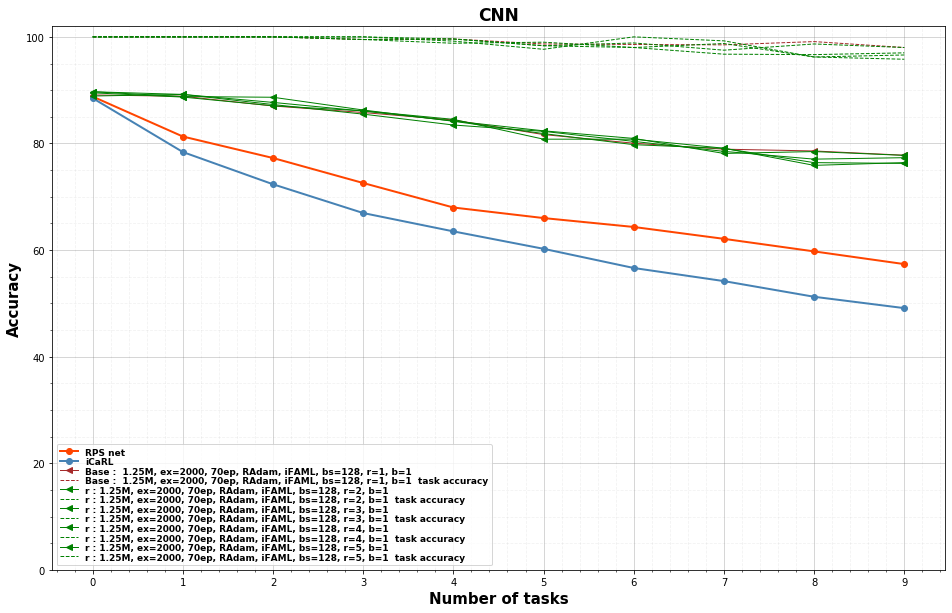

In [42]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(10)
icarl = [88.5, 78.39, 72.34, 66.94, 63.50, 60.23, 56.63, 54.17, 51.23, 49.10]
ours = [88.8, 81.3, 77.266667, 72.575, 67.98, 66.0, 64.328571, 62.1, 59.744444, 57.36]

chunks = 20

plt.figure(figsize=(16,10))

plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="RPS net")
plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(icarl)
    z2 = np.zeros_like(icarl)
    ps = "models/" + "/".join(p[0].split("/")[1:])
    try:
        z = np.load(p[0]+"/meta_"+str(chunks)+".npy")
        z2 = np.load(p[0]+"/meta_task_"+str(chunks)+".npy")
        if(np.sum(z>0)<10):
            for j in range(np.sum(z>0), 10):
                try:
                    z[j], z2[j] = get_mata_score(ps , j, chunks)
                except Exception as e:
                    pass
            np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
            np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
    except:
        for j in range(10):
            try:
                z[j], z2[j] = get_mata_score(ps , j, chunks)
            except Exception as e:
#                 print(e)
                pass
        np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
        np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
        
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    plt.plot(x, z2, "--", linewidth=1, c = p[1], label=p[2] + "  task accuracy")
    print(",".join([str(i) for i in z]) )
#     print(",".join([str(i) for i in z2]) )
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(10))
# plt.savefig("meta_10.pdf")
plt.show()